In [1]:
import numpy  as np 
import pandas as pd
from processing import *
from scipy.stats import truncnorm
from fastai.tabular.all import *
import matplotlib as plt

In [2]:
def get_truncated_normal(mean=265, sd=265, low=0, upp=500):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [3]:
fs = 256
interval = 20
k = 10

filenames = ['avatar1', 'avengers1', 'bbc1', 'bear1', 'bighero1', 'creed1', 'edgeoftmr11', 'gunviolence1', 'ironman1', 'joe1', 'lex1', 'vox1']
files = [pd.read_csv(('datasets/{}.csvprocessed.csv').format(name)) for name in filenames]

data_sets = pd.concat(files, ignore_index=True).dropna()

In [4]:
labels = data_sets["Interest"]
    
labels_norm = [1 if x == 4 or x == 5 else 0 for x in labels]

data_sets["Interest"] = labels_norm

interested = np.array(data_sets[data_sets['Interest'] == 1])
uninterested = np.array(data_sets[data_sets['Interest'] == 0])

# print(int(len(interested)/(fs*interval))*fs*interval)
# print(int(len(interested)/(fs*interval))) #53
# print(int(len(uninterested)/(fs*interval))) #41


In [5]:
# interestedN = np.array(np.array_split(interested[:int(len(interested)/(fs*interval))*fs*interval], int((len(interested)/(fs*interval))), axis=0))
interestedN1 = np.array(np.array_split(np.array(np.array_split(interested[:int(len(interested)/(fs*interval))*fs*interval], int((len(interested)/(fs*interval))), axis=0)), k, axis=1)).reshape(10*-1, 512, 6)[:, :, 1:5]

sortedN1 = interestedN1[np.argsort(interestedN1.reshape(-1, 512*4).sum(axis=1))]

print(sortedN1.shape)

mean = np.mean(sortedN1.reshape(-1, 512*4))
std = np.std(sortedN1.reshape(-1, 512*4))

mean_indx = find_nearest(np.mean(sortedN1.reshape(-1, 512*4), axis=1), mean)
std_indx = find_nearest(np.mean(sortedN1.reshape(-1, 512*4), axis=1), std)

r = get_truncated_normal(mean=mean_indx, sd=int(std_indx/2), low=0, upp=len(sortedN1))
print(int(r.rvs()))

new_pos_segments = []
for n in range(500):
    ind = [interestedN1[int(r.rvs())] for x in range(10)]
    new_pos_segments.append(np.concatenate(ind, axis=0))

new_pos_segments = np.array(new_pos_segments)
# print(new_pos_segments.shape)

(530, 512, 4)
52


In [6]:
uninterestedN1 = np.array(np.array_split(np.array(np.array_split(uninterested[:int(len(uninterested)/(fs*interval))*fs*interval], int((len(uninterested)/(fs*interval))), axis=0)), k, axis=1)).reshape(10*-1, 512, 6)[:, :, 1:5]

sortedUN1 = uninterestedN1[np.argsort(uninterestedN1.reshape(-1, 512*4).sum(axis=1))]

print(sortedUN1.shape)

Umean = np.mean(sortedUN1.reshape(-1, 512*4))
Ustd = np.std(sortedUN1.reshape(-1, 512*4))

Umean_indx = find_nearest(np.mean(sortedUN1.reshape(-1, 512*4), axis=1), Umean)
Ustd_indx = find_nearest(np.mean(sortedUN1.reshape(-1, 512*4), axis=1), Ustd)

Ur = get_truncated_normal(mean=Umean_indx, sd=int(Ustd_indx/2), low=0, upp=len(sortedUN1))
print(int(Ur.rvs()))


new_neg_segments = []
for n in range(500):
    ind = [uninterestedN1[int(Ur.rvs())] for x in range(10)]
    new_neg_segments.append(np.concatenate(ind, axis=0))

new_neg_segments = np.array(new_neg_segments)
# print(new_neg_segments.shape)

(410, 512, 4)
6


In [7]:
augmented_batches = np.concatenate((new_neg_segments, new_pos_segments), axis=0).reshape(-1*5120, 4, order='F')

print(augmented_batches.shape)

(5120000, 4)


In [11]:
labels = np.concatenate((np.zeros(500), np.full(500, 1)))
# print(labels.shape)

features = PSD(augmented_batches, fs, filtering=True)

# print(features)

normalized = pd.DataFrame(descriptive_stats(features))

  0%|          | 0/4 [00:00<?, ?it/s]

(5120000, 4)


100%|██████████| 1000/1000 [00:11<00:00, 85.17it/s]


(1000, 97)


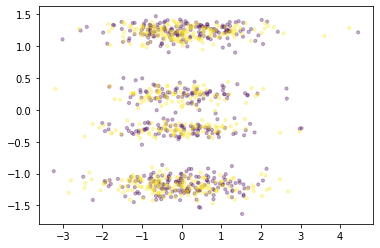

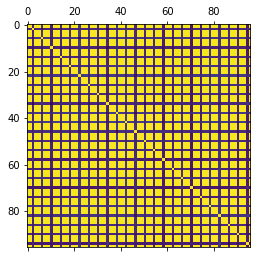

(1000, 97)


In [40]:
normalized["label"] = labels

plt.scatter(normalized.iloc[:, 50], normalized.iloc[:, 40], c=normalized.iloc[:, -1], alpha=0.3, cmap='viridis', s=10)
plt.matshow(normalized.iloc[:, :96].corr())
plt.show()

print(normalized.shape)

In [ ]:
procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(df = normalized, procs=procs, cont_names=list(normalized.columns)[:-1], 
                                 y_names="label", y_block=CategoryBlock, bs=64)

In [9]:
f1_score = F1Score()
learn = tabular_learner(dls, metrics=[accuracy])


In [10]:
learn.fit_one_cycle(30) # cbs=EarlyStoppingCallback(min_delta=0.1, patience=2)
# learn.recorder.plot_losses()
# algo = svm_model(normalized, labels)
# search = random_search_svm(normalized, labels)
# print(search.best_params_)


epoch,train_loss,valid_loss,accuracy,time
0,0.733669,0.696128,0.470000,00:00
1,0.727360,0.709919,0.485000,00:00
2,0.709354,0.730450,0.445000,00:00
3,0.690585,0.741675,0.460000,00:00
4,0.669822,0.769080,0.450000,00:00
5,0.647714,0.779813,0.460000,00:00
6,0.634589,0.805680,0.450000,00:00
7,0.612246,0.820162,0.470000,00:00
8,0.592004,0.881848,0.440000,00:00
9,0.569757,0.931046,0.465000,00:00
